In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

queries = ('q11', 'q12', 'q13', 'q21', 'q22', 'q23', 'q31', 'q32', 'q33', 'q34', 'q41', 'q42', 'q43')

In [3]:
results = pd.DataFrame()
for q in queries:
    data_sync = pd.read_csv(f'{q}-performance-sync.log', header=None, names=['execution_time_ms'])
    data_async = pd.read_csv(f'{q}-performance.log', header=None, names=['execution_time_ms'])
    data_fusion = pd.read_csv(f'{q}-performance-fusion.log', header=None, names=['execution_time_ms'])
    data_heavydb_transformed = pd.read_csv(f'heavydb_perf/transformed/{q}.txt', header=None, names=['execution_time_ms'])
    data_heavydb_original = pd.read_csv(f'heavydb_perf/original/{q}.txt', header=None, names=['execution_time_ms'])
    results[f'{q}_sync'] = data_sync['execution_time_ms']
    results[f'{q}_async'] = data_async['execution_time_ms']
    results[f'{q}_fusion'] = data_fusion['execution_time_ms']
    results[f'{q}_heavydb_transformed'] = data_heavydb_transformed['execution_time_ms']
    results[f'{q}_heavydb_original'] = data_heavydb_original['execution_time_ms']

results.describe()

,q11_sync,q11_async,q11_fusion,q11_heavydb_transformed,q11_heavydb_original,q12_sync,q12_async,q12_fusion,q12_heavydb_transformed,q12_heavydb_original,...,q42_sync,q42_async,q42_fusion,q42_heavydb_transformed,q42_heavydb_original,q43_sync,q43_async,q43_fusion,q43_heavydb_transformed,q43_heavydb_original
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,13.066991,12.740236,13.289028,18.020000,14.590000,14.023130,13.684812,13.480461,15.980000,16.040000,...,16.503086,15.135067,17.515489,52.390000,50.470000,14.213607,12.481374,19.577448,54.940000,66.120000
std,0.058390,0.184307,14.848733,5.508451,4.114755,0.072740,0.175961,13.061326,13.041488,14.127071,...,1.104309,0.774422,12.349946,16.095608,14.940593,1.048972,0.903446,9.072976,85.361006,82.694189
min,13.007900,12.659700,8.178630,11.000000,11.000000,13.943600,13.607900,8.284820,11.000000,10.000000,...,14.834000,13.981400,12.714300,44.000000,45.000000,12.864300,11.603900,12.835000,41.000000,52.000000
25%,13.040025,12.678350,8.584995,13.750000,12.000000,13.989675,13.630175,8.670010,12.000000,12.000000,...,15.571700,14.214975,12.841200,45.000000,45.000000,13.154550,11.771575,15.882475,43.000000,53.000000
50%,13.056750,12.687000,8.802410,17.500000,13.000000,14.008150,13.637250,8.873155,13.000000,13.000000,...,16.354650,15.414100,13.169450,53.000000,46.000000,14.339450,12.058800,16.892950,46.000000,57.000000
75%,13.074275,12.704500,8.930260,21.000000,17.000000,14.038375,13.646550,9.099675,18.000000,18.000000,...,17.344150,15.527150,15.069975,55.000000,53.000000,14.808900,13.134150,17.841775,51.000000,62.000000
max,13.519900,14.070100,93.969200,43.000000,44.000000,14.484600,15.004200,70.097100,141.000000,152.000000,...,19.253400,17.511300,90.794400,204.000000,191.000000,17.193600,15.427900,53.105400,899.000000,883.000000


In [4]:
results.head(50).describe()

,q11_sync,q11_async,q11_fusion,q11_heavydb_transformed,q11_heavydb_original,q12_sync,q12_async,q12_fusion,q12_heavydb_transformed,q12_heavydb_original,...,q42_sync,q42_async,q42_fusion,q42_heavydb_transformed,q42_heavydb_original,q43_sync,q43_async,q43_fusion,q43_heavydb_transformed,q43_heavydb_original
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,13.056242,12.741662,16.993800,19.900000,15.140000,14.010114,13.682212,17.212999,16.540000,16.720000,...,16.417116,15.120226,21.307250,54.92000,51.100000,14.050908,12.580438,22.494150,63.680000,73.860000
std,0.036912,0.212673,20.099583,6.383173,5.087038,0.069158,0.204830,17.395275,18.188593,19.783564,...,1.069227,0.796449,16.653418,22.08041,20.655829,0.805167,0.881624,12.122759,120.610765,116.867448
min,13.007900,12.659700,8.178630,12.000000,11.000000,13.943600,13.607900,8.284820,11.000000,10.000000,...,14.834000,13.981400,12.714300,44.00000,45.000000,12.864300,11.668800,12.835000,41.000000,52.000000
25%,13.038825,12.680900,8.704988,15.000000,12.000000,13.978875,13.628800,8.652610,12.000000,12.000000,...,15.495775,14.158350,12.841275,45.75000,45.000000,13.105425,11.787075,16.506450,43.000000,53.000000
50%,13.044600,12.687300,8.843995,18.000000,13.000000,14.001750,13.633900,8.937930,13.000000,12.500000,...,16.370150,15.402900,13.658300,54.00000,46.000000,14.339450,12.134600,16.902450,46.000000,57.000000
75%,13.066275,12.703200,9.341382,24.000000,17.750000,14.020075,13.647650,11.120675,16.000000,18.000000,...,17.187275,15.523500,15.583625,56.00000,50.000000,14.496925,13.169725,17.954525,51.000000,62.000000
max,13.245000,14.070100,93.969200,43.000000,44.000000,14.454100,15.004200,70.097100,141.000000,152.000000,...,19.253400,16.909900,90.794400,204.00000,191.000000,15.862300,14.858900,53.105400,899.000000,883.000000


In [5]:
results[50:].describe()

,q11_sync,q11_async,q11_fusion,q11_heavydb_transformed,q11_heavydb_original,q12_sync,q12_async,q12_fusion,q12_heavydb_transformed,q12_heavydb_original,...,q42_sync,q42_async,q42_fusion,q42_heavydb_transformed,q42_heavydb_original,q43_sync,q43_async,q43_fusion,q43_heavydb_transformed,q43_heavydb_original
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,13.077740,12.738810,9.584256,16.140000,14.040000,14.036146,13.687412,9.747923,15.420000,15.360000,...,16.589056,15.149908,13.723728,49.860000,49.840000,14.376306,12.382310,16.660746,46.200000,58.380000
std,0.072732,0.152963,3.669508,3.653402,2.777166,0.074577,0.143483,3.694609,3.488114,3.299722,...,1.142609,0.759552,1.215290,4.776687,4.850247,1.233217,0.922929,1.412424,4.342481,5.996223
min,13.016400,12.664100,8.261810,11.000000,11.000000,13.966900,13.625400,8.410490,11.000000,12.000000,...,14.898700,14.043600,12.800200,44.000000,45.000000,12.974500,11.603900,13.497500,41.000000,52.000000
25%,13.048525,12.675250,8.535618,12.000000,12.000000,13.996525,13.632775,8.723220,12.000000,12.000000,...,15.708075,14.384975,12.841375,45.000000,45.000000,13.242125,11.762200,15.864050,43.000000,53.000000
50%,13.064500,12.685150,8.700070,16.000000,12.500000,14.025900,13.638750,8.853590,15.000000,14.500000,...,16.353150,15.422700,12.872400,49.000000,49.000000,14.288000,12.013700,16.856000,43.000000,56.500000
75%,13.077450,12.705075,8.851075,19.000000,16.500000,14.047300,13.645225,9.045810,19.000000,19.000000,...,17.400225,15.525500,14.420825,54.000000,54.000000,15.365700,12.972500,17.290875,50.000000,63.000000
max,13.519900,13.317000,24.597200,23.000000,20.000000,14.484600,14.267600,24.729500,21.000000,21.000000,...,18.899400,17.511300,16.814100,62.000000,61.000000,17.193600,15.427900,21.056500,55.000000,80.000000


In [6]:
comparison = []

for q in queries:
    sync_avg = results[f'{q}_sync'].mean()
    async_avg = results[f'{q}_async'].mean()
    fusion_avg = results[results[f'{q}_fusion'] < 20.0][f'{q}_fusion'].mean()
    heavydb_transformed_avg = results[1:][f'{q}_heavydb_transformed'].mean()
    heavydb_original_avg = results[1:][f'{q}_heavydb_original'].mean()
    speedup_async = (sync_avg - async_avg) / sync_avg
    speedup_fusion = (sync_avg - fusion_avg) / sync_avg
    fusion_async = (async_avg - fusion_avg) / async_avg
    heavydb_original_async = (async_avg - heavydb_original_avg) / async_avg
    heavydb_transformed_async = (async_avg - heavydb_transformed_avg) / async_avg
    # print(f'{q}: Sync avg = {sync_avg:5.2f} ms, Async avg = {async_avg:5.2f} ms, Fusion avg = {fusion_avg:5.2f} ms, Speedup async on sync = {speedup_async:6.2%}, Speedup fusion on sync = {speedup_fusion:6.2%}')

    comparison.append({
        'query': q,
        'sync_avg': sync_avg,
        'async_avg': async_avg,
        'fusion_avg': fusion_avg,
        'heavydb_transformed_avg': heavydb_transformed_avg,
        'heavydb_original_avg': heavydb_original_avg,
        'async_sync': speedup_async * 100,
        'fusion_sync': speedup_fusion * 100,
        'fusion_async': fusion_async * 100,
        'heavydb_original_async': heavydb_original_async * 100,
        'heavydb_transformed_async': heavydb_transformed_async * 100,
    })

comparison = pd.DataFrame(comparison)
# comparison.set_index('query', inplace=True)
comparison

,query,sync_avg,async_avg,fusion_avg,heavydb_transformed_avg,heavydb_original_avg,async_sync,fusion_sync,fusion_async,heavydb_original_async,heavydb_transformed_async
0,q11,13.066991,12.740236,8.821377,17.767677,14.292929,2.500614,32.491136,30.759703,-12.187320,-39.461127
1,q12,14.023130,13.684812,8.897072,14.717172,14.666667,2.412571,36.554307,34.985793,-7.174776,-7.543836
2,q13,13.997501,13.627748,8.932599,13.232323,14.525253,2.641564,36.184331,34.452861,-6.585861,2.901615
3,q21,12.816319,12.031894,10.950169,31.010101,29.818182,6.120517,14.560737,8.990484,-147.826168,-157.732498
4,q22,10.199652,9.333765,8.146779,29.919192,31.898990,8.489377,20.126898,12.717126,-241.759071,-220.547931
5,q23,8.615798,7.784594,6.433541,29.545455,28.696970,9.647448,25.328555,17.355466,-268.637989,-279.537529
6,q31,15.705098,14.747863,13.692898,31.313131,27.555556,6.095059,12.812402,7.153343,-86.844396,-112.323177
7,q32,10.701047,9.443966,9.536919,53.353535,51.707071,11.747272,10.878631,-0.984264,-447.514391,-464.948430
8,q33,9.606535,8.106762,10.185099,51.151515,49.000000,15.612004,-6.022608,-25.637073,-504.433667,-530.973426
9,q34,9.371616,7.872036,9.659177,52.707071,51.797980,16.001298,-3.068425,-22.702402,-557.999775,-569.548133


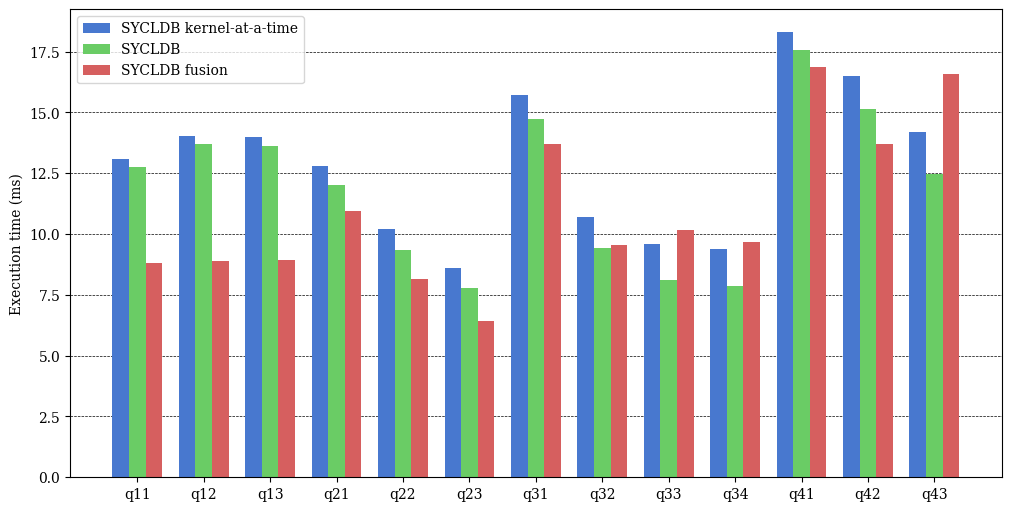

In [7]:
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.style.use('seaborn-v0_8-muted')

labels_mapping = {
    # 'heavydb_original_avg': 'HeavyDB',
    'sync_avg': 'SYCLDB kernel-at-a-time',
    'async_avg': 'SYCLDB ',
    'fusion_avg': 'SYCLDB fusion',
}

x = np.arange(len(comparison))
width = 1 / (len(labels_mapping) + 1)
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))

#iterate on some columns and plot them in a single bar chart
for col, label in labels_mapping.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, comparison[col], width=width, label=label)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.legend()
# ax.set_ylim(0, 60)
ax.set_xticks(x + width, comparison['query'])
ax.set_ylabel('Execution time (ms)')
ax.set_axisbelow(True)
ax.grid(color='black', linestyle='--', linewidth=0.5, zorder=1000, axis='y')

plt.show()

In [8]:
results_cxl = pd.DataFrame()

for q in queries:
    sync_df = pd.read_csv(f'{q}-performance-sync-cxl.log', header=None, names=['execution_time_ms'])
    async_df = pd.read_csv(f'{q}-performance-async-cxl.log', header=None, names=['execution_time_ms'])
    fusion_df = pd.read_csv(f'{q}-performance-cxl.log', header=None, names=['execution_time_ms'])

    results_cxl[f'{q}_sync'] = sync_df['execution_time_ms']
    results_cxl[f'{q}_async'] = async_df['execution_time_ms']
    results_cxl[f'{q}_fusion'] = fusion_df['execution_time_ms']

results_cxl.describe()

,q11_sync,q11_async,q11_fusion,q12_sync,q12_async,q12_fusion,q13_sync,q13_async,q13_fusion,q21_sync,...,q34_fusion,q41_sync,q41_async,q41_fusion,q42_sync,q42_async,q42_fusion,q43_sync,q43_async,q43_fusion
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,7.336749,6.950151,9.748027,7.480610,7.138039,10.873635,7.483421,7.108058,9.433124,5.611103,...,13.773686,8.757289,7.844628,15.517942,7.902888,6.899841,15.390461,6.958989,5.160976,15.506199
std,0.211763,0.018197,14.855124,0.037796,0.015252,18.580545,0.045213,0.017948,16.920892,10.649121,...,11.672271,0.152025,0.066664,12.296717,0.174700,0.087539,17.631538,0.150585,0.104624,11.880568
min,7.265460,6.908720,3.924410,7.424670,7.103940,3.262820,7.449810,7.079930,3.244110,4.370510,...,5.235650,8.666360,7.750420,11.153100,7.680380,6.787440,9.779530,6.833180,4.964030,11.537500
25%,7.299835,6.940392,4.901817,7.465530,7.130800,3.410198,7.466132,7.100548,3.325040,4.463493,...,10.425300,8.708032,7.816520,11.218975,7.848635,6.853080,9.926787,6.899707,5.136178,11.563050
50%,7.310225,6.947635,5.126020,7.478720,7.137390,4.447370,7.474295,7.105935,4.327095,4.523165,...,10.433400,8.739610,7.838315,11.221300,7.882550,6.889060,9.933310,6.934425,5.174730,11.565850
75%,7.321115,6.957540,5.475615,7.487570,7.142658,5.903723,7.489695,7.112785,4.887903,4.583723,...,10.440600,8.766908,7.861590,11.223525,7.940772,6.932507,10.977675,6.964735,5.197740,11.568025
max,9.391660,7.075760,93.847400,7.805730,7.239370,129.988000,7.792940,7.234380,110.772000,111.011000,...,84.097500,10.192300,8.356090,52.575000,9.449410,7.576070,143.886000,8.202850,5.964000,56.035600


In [10]:
comparison_cxl = []

for q in queries:
    sync_avg = results_cxl[f'{q}_sync'].mean()
    async_avg = results_cxl[f'{q}_async'].mean()
    fusion_avg = results_cxl[results_cxl[f'{q}_fusion'] < 12.0][f'{q}_fusion'].mean()
    speedup_async = (sync_avg - async_avg) / sync_avg
    speedup_fusion = (sync_avg - fusion_avg) / sync_avg
    fusion_async = (async_avg - fusion_avg) / async_avg

    comparison_cxl.append({
        'query': q,
        'sync_avg': sync_avg,
        'async_avg': async_avg,
        'fusion_avg': fusion_avg,
        'async_sync': speedup_async * 100,
        'fusion_sync': speedup_fusion * 100,
        'fusion_async': fusion_async * 100,
    })

comparison_cxl = pd.DataFrame(comparison_cxl)
comparison_cxl

,query,sync_avg,async_avg,fusion_avg,async_sync,fusion_sync,fusion_async
0,q11,7.336749,6.950151,5.142956,5.269335,29.901432,26.002243
1,q12,7.480610,7.138039,4.198323,4.579461,43.877273,41.183809
2,q13,7.483421,7.108058,4.225651,5.015932,43.533166,40.551258
3,q21,5.611103,3.984008,5.020019,28.997785,10.534201,-26.004237
4,q22,4.242118,3.817336,5.505911,10.013446,-29.791561,-44.234394
5,q23,3.986156,3.468662,4.510222,12.982283,-13.147161,-30.027729
6,q31,6.089624,5.566903,8.137356,8.583785,-33.626578,-46.173825
7,q32,4.540167,3.533796,8.340710,22.165960,-83.709301,-136.026937
8,q33,4.553606,3.531522,9.408877,22.445587,-106.624746,-166.425518
9,q34,4.286777,3.005747,10.338907,29.883278,-141.181377,-243.971267


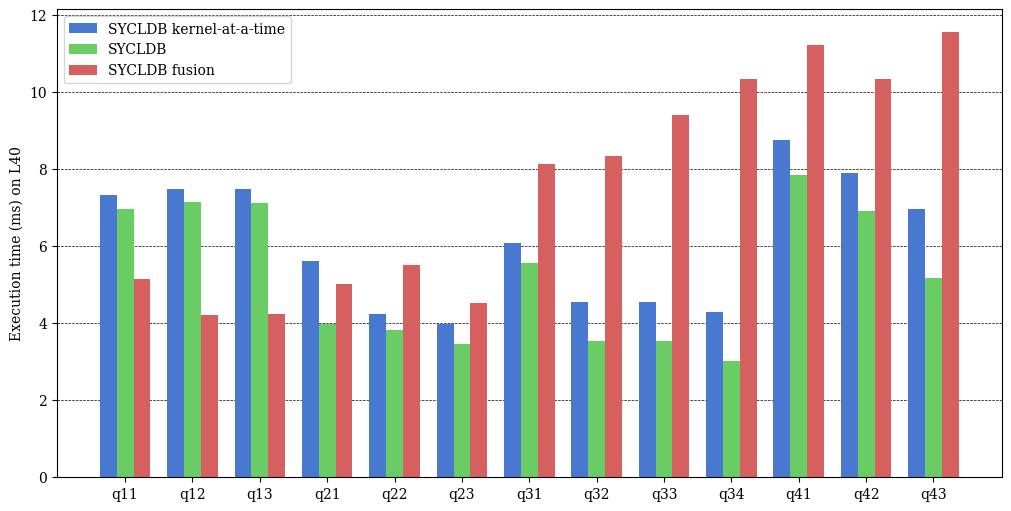

In [11]:
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.style.use('seaborn-v0_8-muted')

labels_mapping = {
    # 'heavydb_original_avg': 'HeavyDB',
    'sync_avg': 'SYCLDB kernel-at-a-time',
    'async_avg': 'SYCLDB',
    'fusion_avg': 'SYCLDB fusion',
}

x = np.arange(len(comparison_cxl))
width = 1 / (len(labels_mapping) + 1)
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 5))

#iterate on some columns and plot them in a single bar chart
for col, label in labels_mapping.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, comparison_cxl[col], width=width, label=label)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

ax.legend()
# ax.set_ylim(0, 60)
ax.set_xticks(x + width, comparison_cxl['query'])
ax.set_ylabel('Execution time (ms) on L40')
ax.set_axisbelow(True)
ax.grid(color='black', linestyle='--', linewidth=0.5, zorder=1000, axis='y')

plt.show()